In [1]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 6
from tqdm import tqdm_notebook as tqdm

!pip install dateparser
import dateparser

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

     |████████████████████████████████| 362 kB 2.7 MB/s 


In [2]:
def date_parser(x):
    return pd.datetime.strptime(x, '%d-%m-%Y %H:%M')

train_data = pd.read_csv('../input/train.csv', index_col = 1, parse_dates = [1], date_parser = date_parser)
test_data = pd.read_csv('../input/test.csv', index_col = 1, parse_dates = [1], date_parser = date_parser)
train_data.columns = train_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
y = train_data['count'].resample('D').sum()
train_data = pd.DataFrame(y.astype(int))
train_data.head(20)

,count
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60
2012-08-30,74
2012-08-31,78
2012-09-01,112
2012-09-02,118


In [3]:
train_data.shape

(762, 1)

In [4]:
train_data.isnull().sum()

count    0
dtype: int64

In [5]:
test_data.isnull().sum()

id    0
dtype: int64

In [6]:
train_data.dtypes

count    int64
dtype: object

In [7]:
train_data.nunique()

count    665
dtype: int64

In [8]:
test_ID = test_data['id'].values
test_data = test_data.drop('id', axis = 1)
#train_data = train_data.drop('id', axis = 1)
train_data.head()

,count
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


In [9]:
train_data.index[1]

Timestamp('2012-08-26 00:00:00', freq='D')

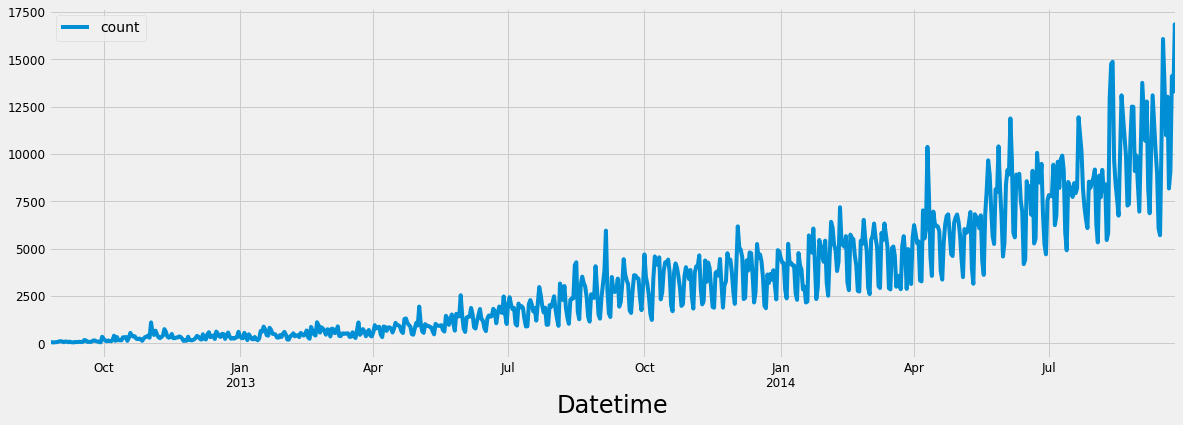

In [10]:
train_data.plot()
plt.show()

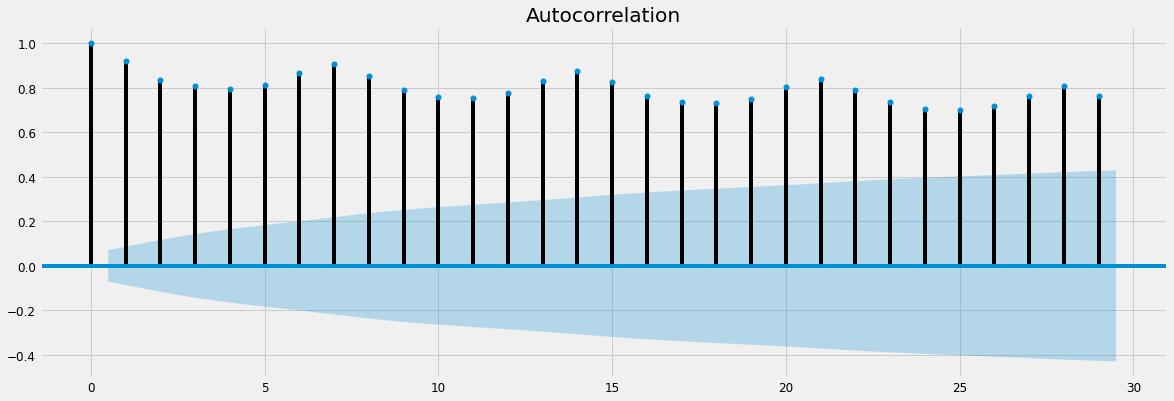

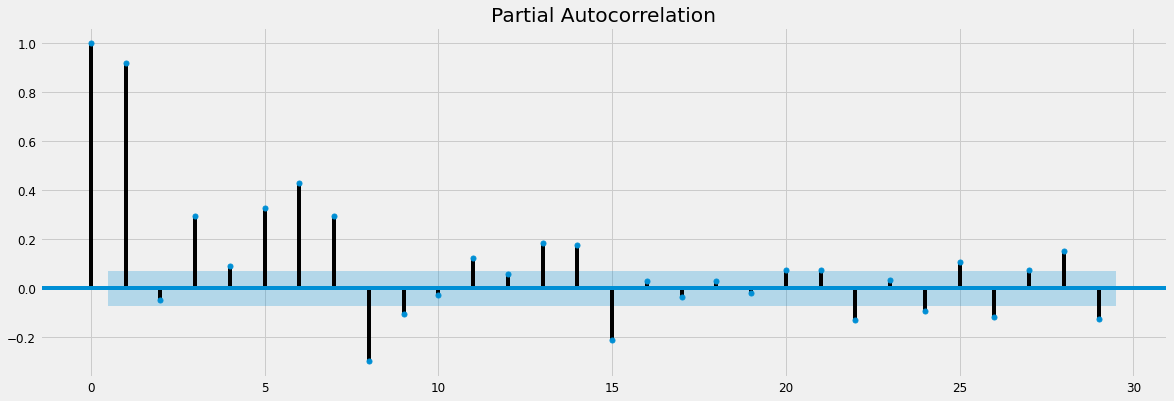

In [11]:
plot_acf(train_data)
plt.show()
plot_pacf(train_data)
plt.show()

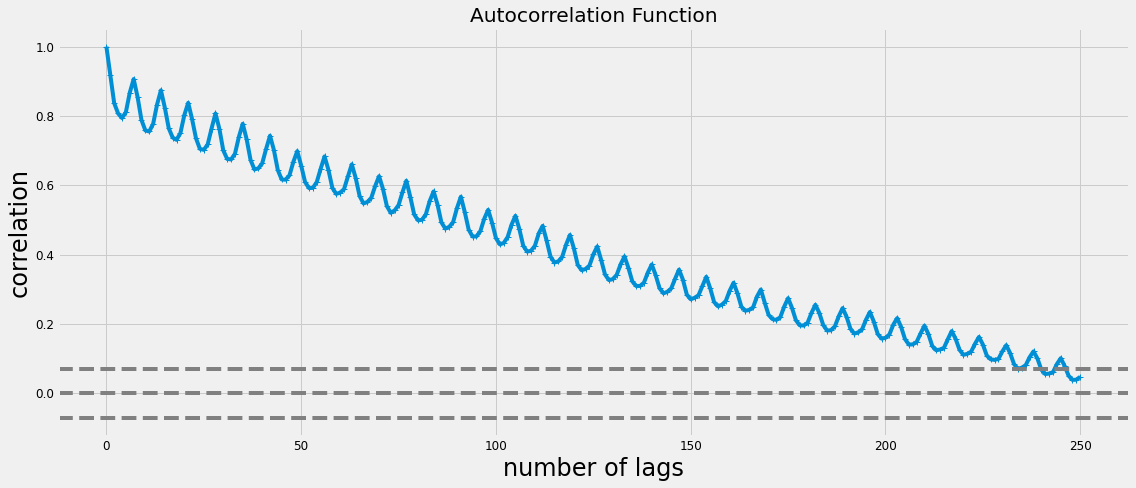

In [12]:
#calling auto correlation function
lag_acf = acf(train_data, nlags = 250)
#Plot ACF:
plt.figure(figsize = (16, 7))
plt.plot(lag_acf, marker = '+')
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(train_data)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(train_data)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

## Dickey–Fuller test

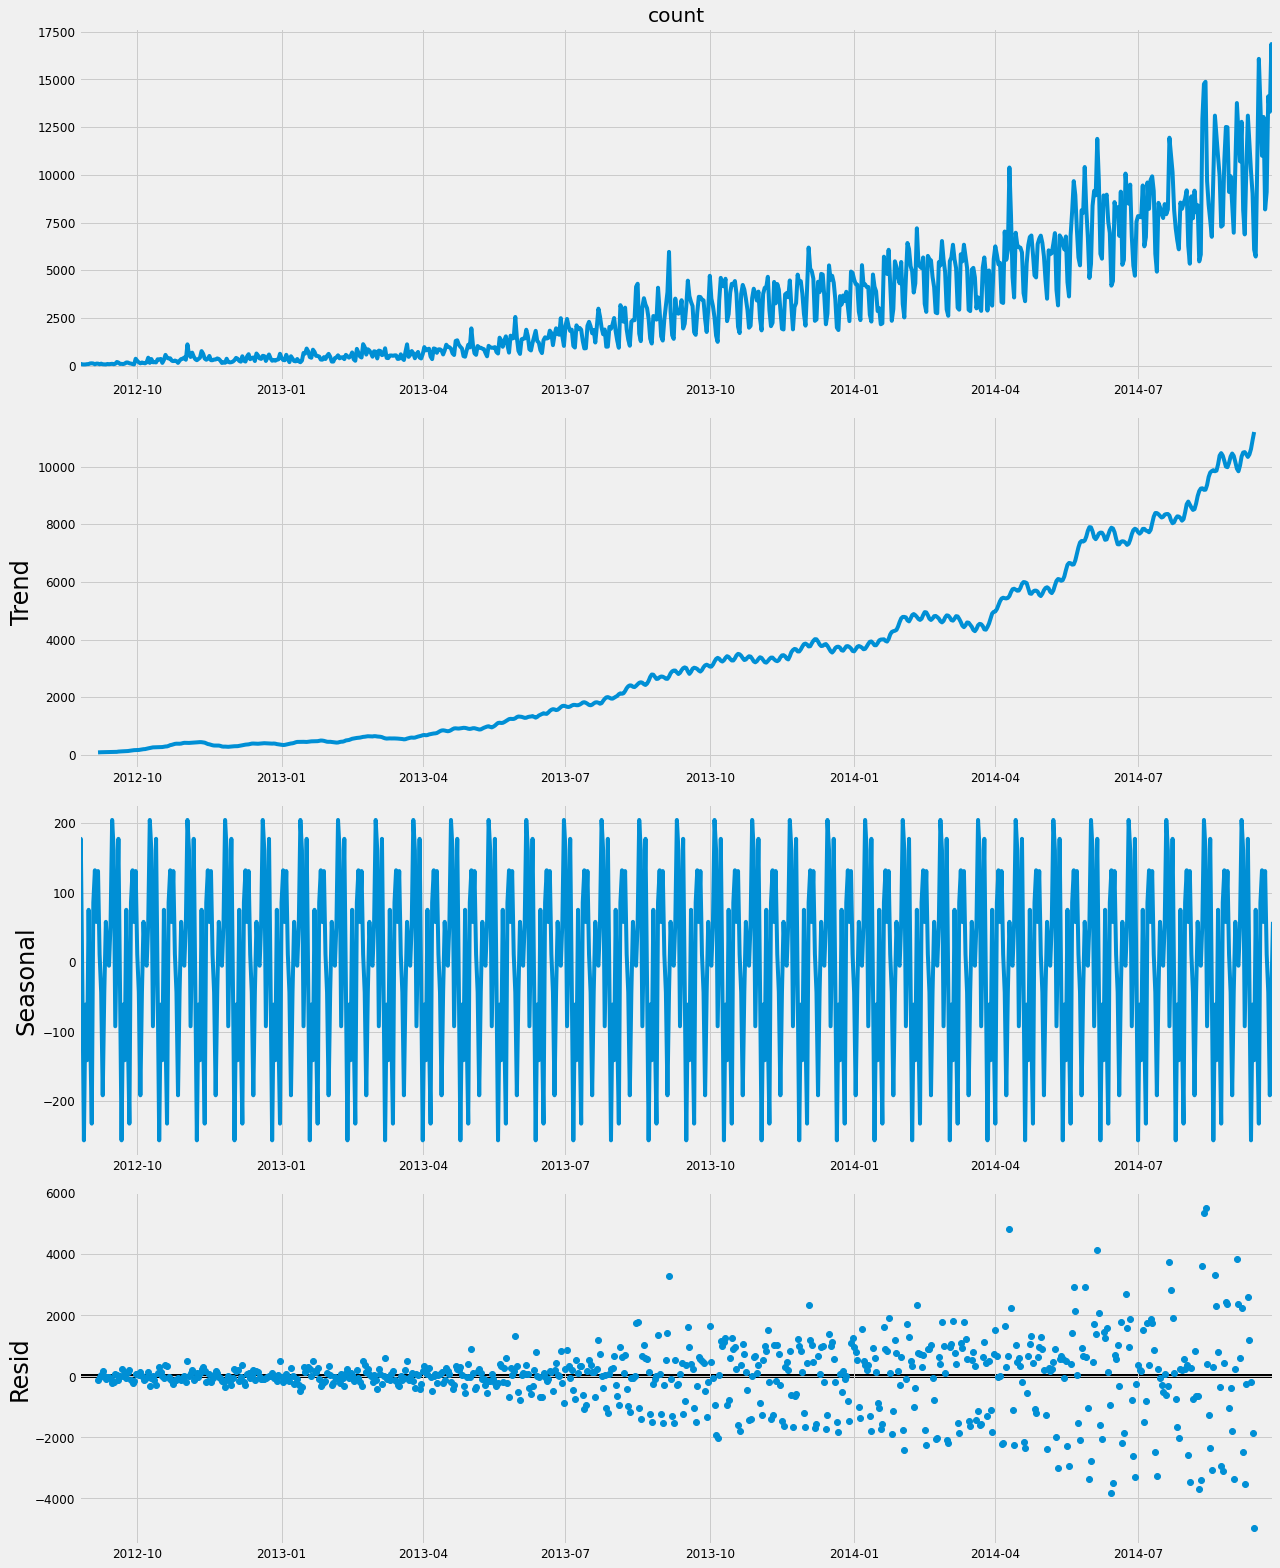

In [13]:
rcParams['figure.figsize'] = 18, 22
sm.tsa.seasonal_decompose(train_data['count'], freq = 24).plot()
result = sm.tsa.stattools.adfuller(train_data['count'])
plt.show()

### Find best params for  SARIMAX  (p, d, q), (P, D, Q)n and seasonal 

In [14]:
X = train_data.values
train = X[0:535] # 534 data as train data
test = X[535:]  # 228 data as test data
predictions = []

In [15]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [16]:
param_aic_seasonal = {}
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train, 
                                            order = param, 
                                            seasonal_order = param_seasonal)
            results = mod.fit()
            #print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            param_aic_seasonal[param, param_seasonal] = results.aic
        except:
            continue

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [17]:
{k: v for k, v in sorted(param_aic_seasonal.items(), key = lambda item: item[1])}

{((0, 1, 2), (0, 2, 2, 7)): 7796.930684951293,
 ((2, 1, 1), (1, 2, 2, 7)): 7799.920842095233,
 ((1, 1, 1), (0, 2, 2, 7)): 7803.111540473084,
 ((0, 1, 2), (1, 2, 2, 7)): 7815.497107849487,
 ((1, 0, 0), (0, 2, 2, 7)): 7819.80760662086,
 ((2, 0, 0), (0, 2, 2, 7)): 7820.750699126269,
 ((1, 0, 0), (1, 2, 2, 7)): 7821.682593762988,
 ((2, 0, 0), (1, 2, 2, 7)): 7822.584092021951,
 ((0, 0, 2), (1, 2, 2, 7)): 7824.596041010183,
 ((1, 0, 0), (2, 2, 2, 7)): 7825.787716970083,
 ((0, 0, 2), (0, 2, 2, 7)): 7830.3909619557935,
 ((0, 1, 1), (1, 2, 2, 7)): 7831.0859096423455,
 ((2, 1, 1), (0, 2, 2, 7)): 7831.107045609186,
 ((0, 1, 1), (2, 2, 2, 7)): 7832.274783464254,
 ((0, 2, 2), (1, 2, 2, 7)): 7833.14707269101,
 ((0, 2, 2), (2, 2, 2, 7)): 7834.158500682681,
 ((1, 1, 2), (1, 2, 2, 7)): 7835.120555233623,
 ((0, 0, 1), (0, 2, 2, 7)): 7836.734523887294,
 ((0, 0, 1), (1, 2, 2, 7)): 7838.228692638588,
 ((0, 0, 1), (2, 2, 2, 7)): 7840.77566952317,
 ((2, 0, 0), (2, 2, 2, 7)): 7845.744319967667,
 ((1, 0, 2), (

## SARIMA

In [18]:
"""
ARIMA(0, 1, 2)x(0, 2, 2, 7)7 - AIC:7796.930684951293
ARIMA(0, 1, 3)x(0, 2, 2, 7)7 - AIC:7798.195336121731
ARIMA(1, 1, 3)x(0, 2, 2, 7)7 - AIC:7800.689430109041
ARIMA(1, 1, 3)x(1, 2, 3, 7)7 - AIC:7801.455544313485
ARIMA(1, 1, 3)x(0, 2, 3, 7)7 - AIC:7817.536127810834
ARIMA(1, 1, 3)x(1, 2, 2, 7)7 - AIC:7821.356956716344

ARIMA(2, 2, 2)x(2, 2, 3, 7)7 - AIC:7812.823078011056
ARIMA(2, 2, 2)x(1, 2, 3, 7)7 - AIC:7813.068983822397

ARIMA(0, 0, 1)x(1, 2, 2, 7)7 - AIC:7838.228692638588
ARIMA(0, 0, 1)x(1, 2, 3, 7)7 - AIC:7840.423833342043
ARIMA(0, 0, 1)x(0, 2, 2, 7)7 - AIC:7836.734523887294
ARIMA(0, 0, 1)x(0, 2, 3, 7)7 - AIC:7838.20996590997
ARIMA(0, 0, 1)x(0, 2, 4, 7)7 - AIC:7840.067090844341
ARIMA(0, 0, 1)x(0, 2, 5, 7)7 - AIC:7840.052586356935

ARIMA(0, 0, 0)x(0, 2, 2, 7)7 - AIC:7923.896707311315
ARIMA(0, 0, 0)x(0, 2, 3, 7)7 - AIC:7912.299111269296
ARIMA(0, 0, 0)x(0, 2, 4, 7)7 - AIC:7925.219651372339
ARIMA(0, 0, 0)x(0, 2, 5, 7)7 - AIC:7914.754898950585
ARIMA(0, 0, 0)x(0, 3, 5, 7)7 - AIC:7942.688159983001
ARIMA(0, 0, 0)x(1, 2, 2, 7)7 - AIC:7912.265579854375
ARIMA(0, 0, 0)x(1, 2, 3, 7)7 - AIC:7933.789327232746
ARIMA(0, 0, 0)x(1, 2, 4, 7)7 - AIC:7916.247023781987
ARIMA(0, 0, 0)x(1, 2, 5, 7)7 - AIC:7928.90160963447
ARIMA(0, 0, 0)x(4, 2, 2, 7)7 - AIC:7918.9959792007885
ARIMA(0, 0, 0)x(5, 2, 1, 7)7 - AIC:7923.534611519698
ARIMA(0, 0, 0)x(5, 2, 2, 7)7 - AIC:7924.175712677705
ARIMA(0, 0, 0)x(5, 2, 4, 7)7 - AIC:7932.990955173896
ARIMA(0, 0, 0)x(5, 3, 2, 7)7 - AIC:7902.697468081234
"""

'\nARIMA(0, 1, 2)x(0, 2, 2, 7)7 - AIC:7796.930684951293\nARIMA(0, 1, 3)x(0, 2, 2, 7)7 - AIC:7798.195336121731\nARIMA(1, 1, 3)x(0, 2, 2, 7)7 - AIC:7800.689430109041\nARIMA(1, 1, 3)x(1, 2, 3, 7)7 - AIC:7801.455544313485\nARIMA(1, 1, 3)x(0, 2, 3, 7)7 - AIC:7817.536127810834\nARIMA(1, 1, 3)x(1, 2, 2, 7)7 - AIC:7821.356956716344\n\nARIMA(2, 2, 2)x(2, 2, 3, 7)7 - AIC:7812.823078011056\nARIMA(2, 2, 2)x(1, 2, 3, 7)7 - AIC:7813.068983822397\n\nARIMA(0, 0, 1)x(1, 2, 2, 7)7 - AIC:7838.228692638588\nARIMA(0, 0, 1)x(1, 2, 3, 7)7 - AIC:7840.423833342043\nARIMA(0, 0, 1)x(0, 2, 2, 7)7 - AIC:7836.734523887294\nARIMA(0, 0, 1)x(0, 2, 3, 7)7 - AIC:7838.20996590997\nARIMA(0, 0, 1)x(0, 2, 4, 7)7 - AIC:7840.067090844341\nARIMA(0, 0, 1)x(0, 2, 5, 7)7 - AIC:7840.052586356935\n\nARIMA(0, 0, 0)x(0, 2, 2, 7)7 - AIC:7923.896707311315\nARIMA(0, 0, 0)x(0, 2, 3, 7)7 - AIC:7912.299111269296\nARIMA(0, 0, 0)x(0, 2, 4, 7)7 - AIC:7925.219651372339\nARIMA(0, 0, 0)x(0, 2, 5, 7)7 - AIC:7914.754898950585\nARIMA(0, 0, 0)x(0, 3

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  535
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 7)   Log Likelihood               -3893.465
Date:                           Fri, 26 Jun 2020   AIC                           7796.931
Time:                                   22:29:05   BIC                           7818.200
Sample:                                        0   HQIC                          7805.263
                                           - 535                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5796      0.029    -19.667      0.000      -0.637      -0.522
ma.L2         -0.2893      0.033     -8.767

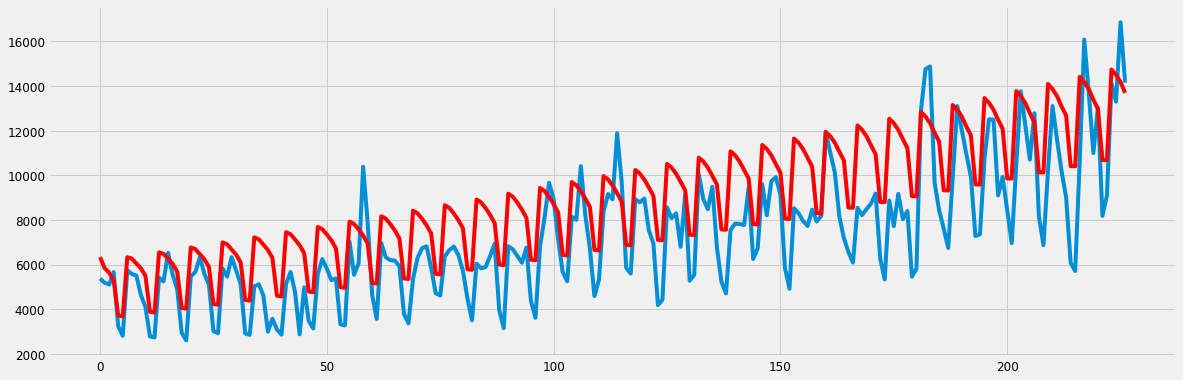

2013686.79215881


In [19]:
# 1. Based on minimal AIC : {((0, 1, 2), (0, 2, 2, 7)): 7796.9306841312355}

mod = sm.tsa.statespace.SARIMAX(train, order = (0, 1, 2), seasonal_order = (0, 2, 2, 7))
results = mod.fit()
print(results.summary())

y_pred = results.predict(start = 535, end = 761, dynamic = True)
rcParams['figure.figsize'] = 18, 6
plt.plot(test)
plt.plot(y_pred, color = 'red')
plt.show()
# preds_old = results.predict(start = 0, end = 761, dynamic = False)
print(y_pred.sum())

In [20]:
train_df = train_data[:]

mod = sm.tsa.statespace.SARIMAX(train_df['count'], order = (0, 1, 2), seasonal_order = (0, 2, 2, 7))
results = mod.fit()
print(results.summary())

y_new = results.predict(start = 762, end = 974, dynamic = True)
y_old = results.predict(start = 0, end = 761, dynamic = False)
print(y_new.sum())

                                     SARIMAX Results                                     
Dep. Variable:                             count   No. Observations:                  762
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 7)   Log Likelihood               -5989.144
Date:                           Fri, 26 Jun 2020   AIC                          11988.288
Time:                                   22:29:10   BIC                          12011.369
Sample:                               08-25-2012   HQIC                         11997.183
                                    - 09-25-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4684      0.025    -18.560      0.000      -0.518      -0.419
ma.L2         -0.4061      0.024    -16.628

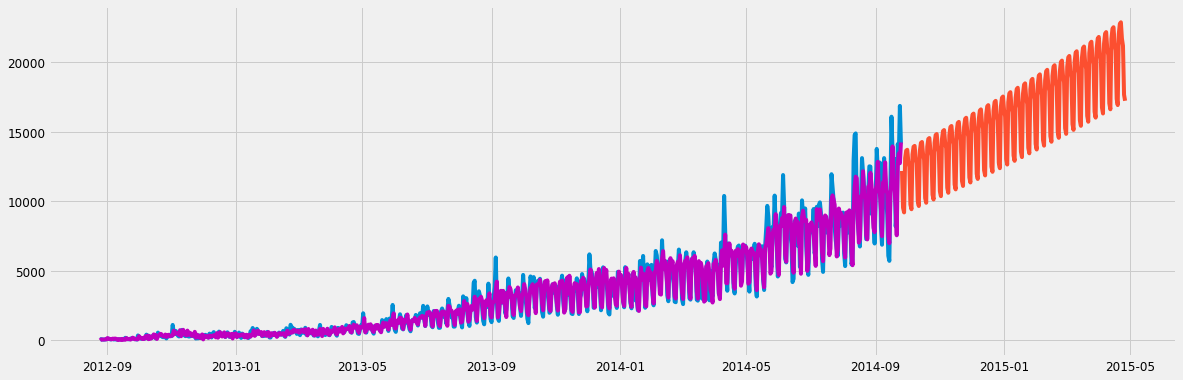

In [21]:
plt.plot(train_data.index, train_data['count'])
plt.plot(y_new.index, y_new)
plt.plot(y_old.index, y_old, 'm')
plt.show()

## Prediction using Prophet

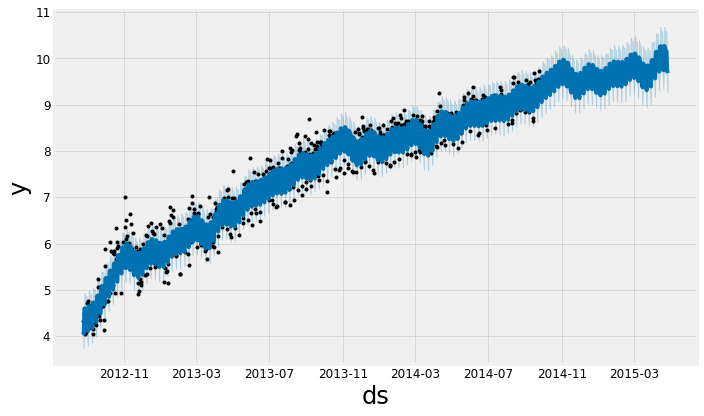

In [22]:
train_data = pd.read_csv('../input/train.csv', parse_dates = [1], date_parser = date_parser)
test_data = pd.read_csv('../input/test.csv', parse_dates = [1], date_parser = date_parser)
train_data.columns = train_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

train_data['date'] = train_data['datetime'].dt.date
train_data = train_data.groupby(['date'])['count'].sum().reset_index()
train_data.columns = ['ds', 'y']
train_data['y'] = np.log(train_data['y'])
model = Prophet(daily_seasonality = False)
model.add_seasonality(name = 'weekly', period = 7, fourier_order = 300)
model.fit(train_data)
future = model.make_future_dataframe(periods = 213)
forecast = model.predict(future)
fig1 = model.plot(forecast)

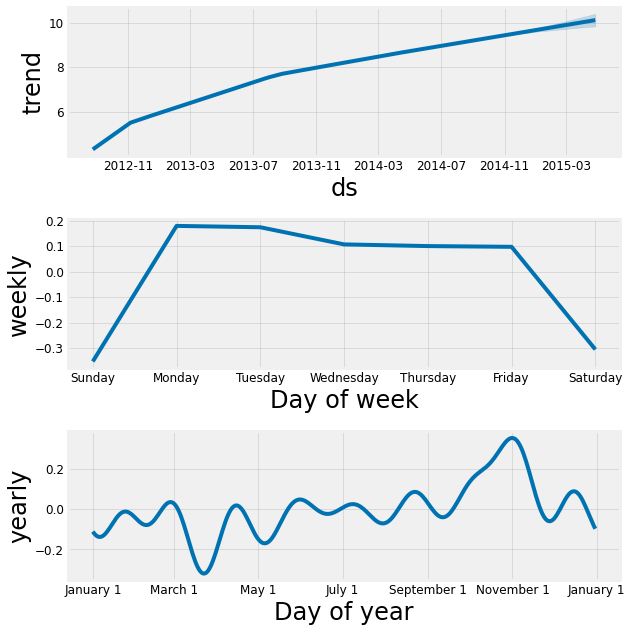

In [23]:
fig2 = model.plot_components(forecast)

In [24]:
f_preds = np.exp(forecast[-213:]['yhat']).values
er = []
listm = [0.044286588, 0.035343014, 0.029911076, 0.024714453, 0.02080223, 0.018621427, 
         0.020023091, 0.023221497, 0.026741002, 0.034555218, 0.049047207, 0.05437526, 
         0.054951351, 0.048600186, 0.051965438, 0.051309072, 0.049999488, 0.051164262, 
         0.052423477, 0.055626605, 0.053455246, 0.049894816, 0.050075828, 0.048892166]
for p in range(len(f_preds)):
    for l in range(len(listm)):
        er.append(f_preds[p]*listm[l])

Result = {'Count': er}

submission_df = pd.DataFrame({
                  "ID": pd.Series([x + 18288 for x in range(5112)]), 
                  "Count": pd.Series(Result['Count'])})
submission_df.to_csv('submission_1.csv', index = False)

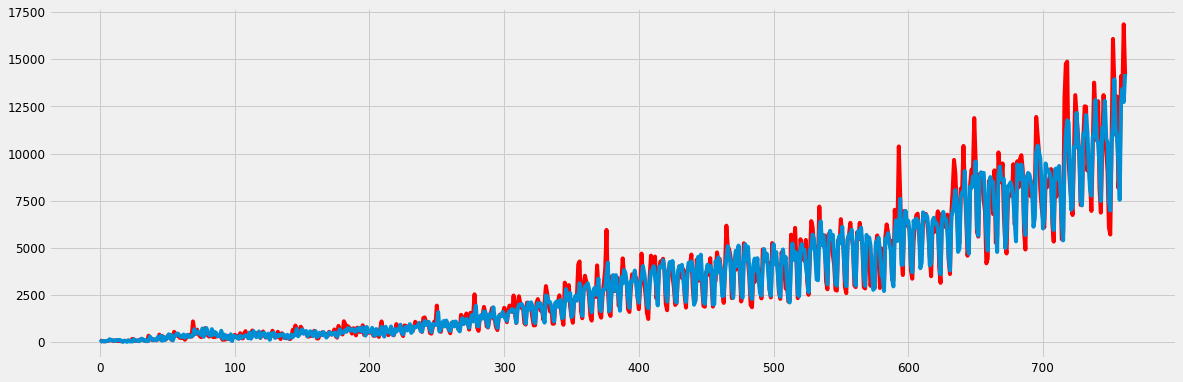

In [25]:
#checking how well the learning happened

y_old_df = y_old.reset_index(name = "count")
y_new_df = y_new.reset_index(name = "count")
plt.plot(range(0, len(y_old_df)), train_df['count'], color = 'red')
plt.plot(range(0, len(y_old_df)), y_old_df['count'])

In [26]:
df = pd.read_csv("../input/train.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'], format = '%d-%m-%Y %H:%M')
df['date'] = df['Datetime'].dt.date
df = df.groupby(['date'])['Count'].sum().reset_index()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.month
df['day'] = df.date.dt.weekday
df['month_start'] = df.date.apply(lambda x: 1 if x.is_month_start else 0)
df['month_end'] = df.date.apply(lambda x: 1 if x.is_month_end else 0)
df['week_start'] = df.day.apply(lambda x: 1 if x == 0 or x == 1 else 0)
df['week_end'] = df.day.apply(lambda x: 1 if x == 5 or x == 6 else 0)
df['month_day'] = df.date.dt.day
df['predicted'] = y_old_df['count']
df['diff'] = df.date.apply(lambda x: (x - dateparser.parse('2012-08-25')).days)
df.head()

,date,Count,month,day,month_start,month_end,week_start,week_end,month_day,predicted,diff
0,2012-08-25,76,8,5,0,0,0,1,25,0.000000,0
1,2012-08-26,88,8,6,0,0,0,1,26,67.365523,1
2,2012-08-27,62,8,0,0,0,1,0,27,72.147830,2
3,2012-08-28,58,8,1,0,0,1,0,28,59.693090,3
4,2012-08-29,60,8,2,0,0,0,0,29,60.388337,4


In [27]:
dfh = df.groupby(['date'])['Count'].sum().reset_index()
dfh.sort_values(['Count'], ascending = [False]).head(50)

,date,Count
760,2014-09-24,16856
752,2014-09-16,16080
718,2014-08-13,14878
717,2014-08-12,14762
761,2014-09-25,14152
758,2014-09-22,14116
738,2014-09-02,13764
753,2014-09-17,13676
759,2014-09-23,13304
724,2014-08-19,13104


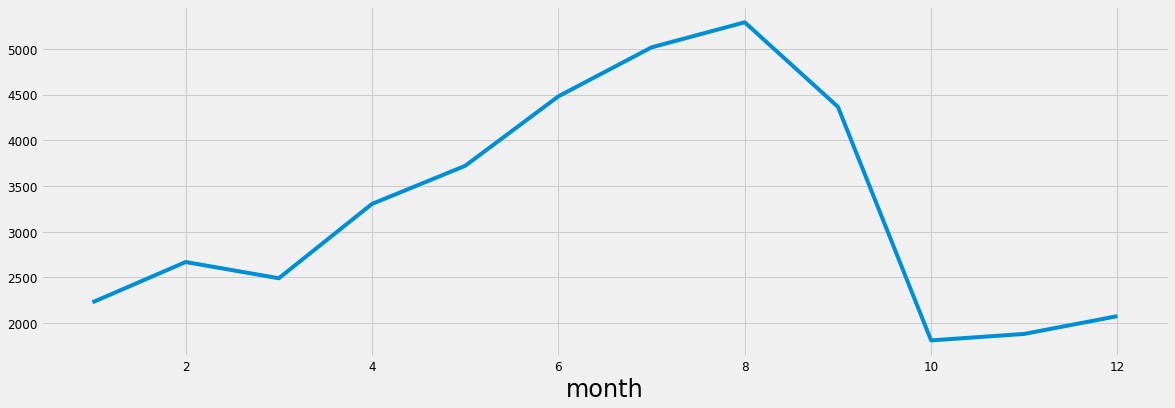

In [28]:
df.groupby(['month'])['Count'].mean().plot()

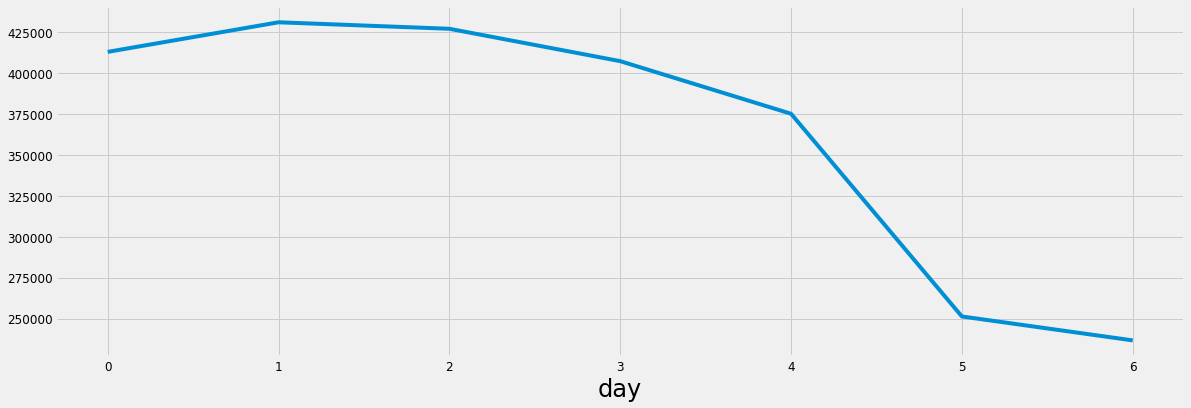

In [29]:
df.groupby(['day'])['Count'].sum().plot()

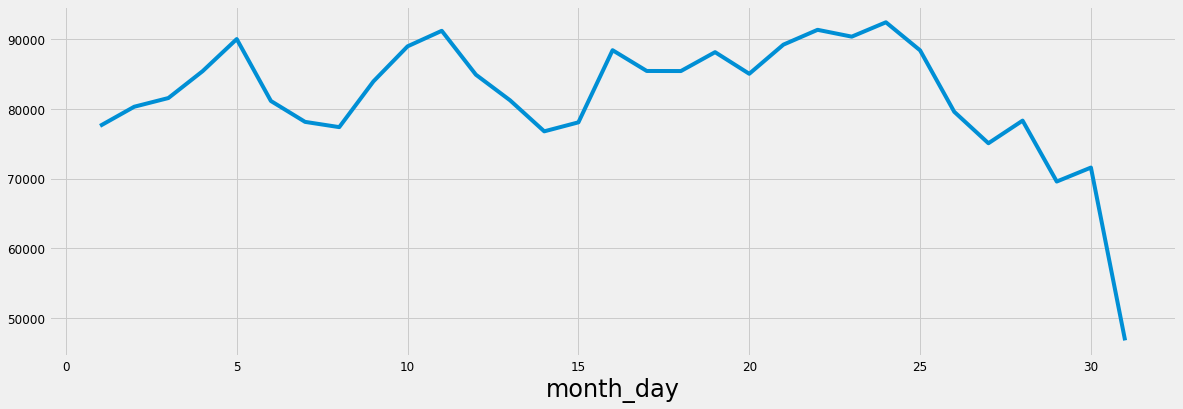

In [30]:
df.groupby(['month_day'])['Count'].sum().plot()

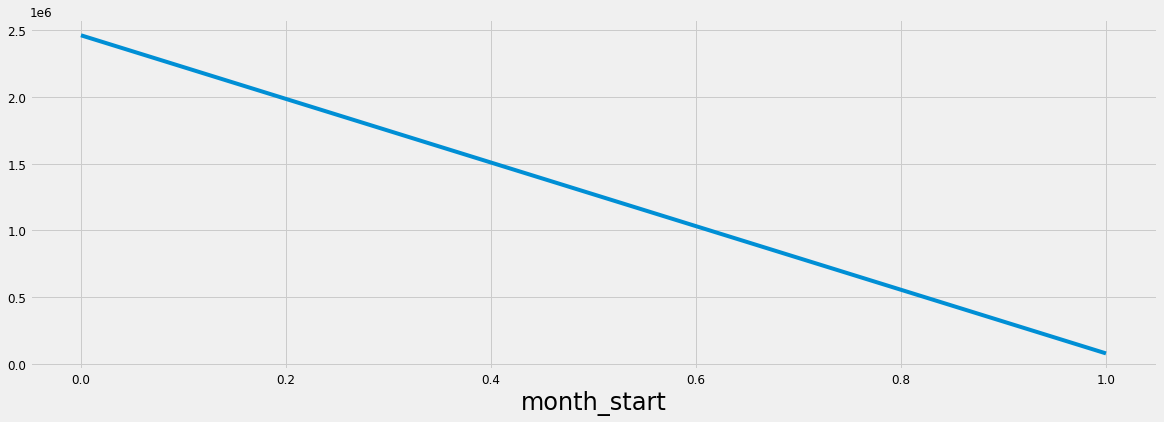

In [31]:
df.groupby(['month_start'])['Count'].sum().plot()

In [32]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None], 
                              actual[:, None]]), axis = 1)
    maxs = np.amax(np.hstack([forecast[:, None], 
                              actual[:, None]]), axis = 1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = 0#acf(fc-test)[1]                      # ACF1
    return({'mape': mape, 'me': me, 'mae': mae, 
            'mpe': mpe, 'rmse': rmse, 'acf1': acf1, 
            'corr': corr, 'minmax': minmax})

In [33]:
new_df = df.drop(['date'], axis = 1)
new_df.shape

(762, 10)

In [34]:
test_df = pd.read_csv("../input/test.csv")
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'], format = '%d-%m-%Y %H:%M')
test_df['date'] = test_df['Datetime'].dt.date
test_df = test_df.groupby(['date']).sum().reset_index()
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['month'] = test_df.date.dt.month
test_df['day'] = test_df.date.dt.weekday
test_df['month_start'] = test_df.date.apply(lambda x: 1 if x.is_month_start else 0)
test_df['month_end'] = test_df.date.apply(lambda x: 1 if x.is_month_end else 0)
test_df['week_start'] = test_df.day.apply(lambda x: 1 if x == 0 or x == 1 else 0)
test_df['week_end'] = test_df.day.apply(lambda x: 1 if x == 5 or x == 6 else 0)
test_df['month_day'] = test_df.date.dt.day
test_df['predicted'] = y_new_df['count']
test_df['diff'] = test_df.date.apply(lambda x: (x - dateparser.parse('2012-08-25')).days)
test_df.head()

,date,ID,month,day,month_start,month_end,week_start,week_end,month_day,predicted,diff
0,2014-09-26,439188,9,4,0,0,0,0,26,12177.504516,762
1,2014-09-27,439764,9,5,0,0,0,1,27,9532.049504,763
2,2014-09-28,440340,9,6,0,0,0,1,28,9200.635795,764
3,2014-09-29,440916,9,0,0,0,1,0,29,13100.968372,765
4,2014-09-30,441492,9,1,0,1,1,0,30,13640.043480,766


In [35]:
X_train = new_df[:]
y_train = X_train['Count']
dropcols = ['Count']
X_train.drop(dropcols, axis = 1, inplace = True)

X_test = new_df[700:]
y_test = X_test['Count']
X_test.drop(dropcols, axis = 1, inplace = True)

testing_df = test_df.drop(["ID", "date"], axis = 1)
testing_df

,month,day,month_start,month_end,week_start,week_end,month_day,predicted,diff
0,9,4,0,0,0,0,26,12177.504516,762
1,9,5,0,0,0,1,27,9532.049504,763
2,9,6,0,0,0,1,28,9200.635795,764
3,9,0,0,0,1,0,29,13100.968372,765
4,9,1,0,1,1,0,30,13640.043480,766
...,...,...,...,...,...,...,...,...,...
208,4,2,0,0,0,0,22,22865.716001,970
209,4,3,0,0,0,0,23,21689.502708,971
210,4,4,0,0,0,0,24,21173.949263,972
211,4,5,0,0,0,1,25,17661.173038,973


In [36]:
linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)

linear1 = linear_model.LinearRegression()
linear1.fit(X_train, np.log(y_train))

rtp = linear.predict(X_test)
rtp1 = np.exp(linear1.predict(X_test))

new_rtp = (rtp + rtp1) / 2

print(forecast_accuracy(np.array(rtp), np.array(y_test)))
print(forecast_accuracy(np.array(rtp1), np.array(y_test)))

for c, cc in enumerate(linear.coef_):
    print(X_train.columns[c])
    print(cc)

{'mape': 0.10866791943179431, 'me': -89.68488560879169, 'mae': 1116.3527632793828, 'mpe': 0.014023684134744722, 'rmse': 1474.657471077956, 'acf1': 0, 'corr': 0.8582357735418423, 'minmax': 0.1010691062752791}
{'mape': 0.2820908295880464, 'me': 1105.1798811121896, 'mae': 2491.5322326831756, 'mpe': 0.18312669814562657, 'rmse': 2923.896162557468, 'acf1': 0, 'corr': 0.36834571581034176, 'minmax': 0.21011603600419282}
month
-2.6455936556408703
day
-14.566588065467654
month_start
0.7880842667315242
month_end
-51.031414657122106
week_start
45.78982636528678
week_end
-64.85843149060014
month_day
-2.4156814518445273
predicted
1.0191676059327845
diff
-0.10230036215409946


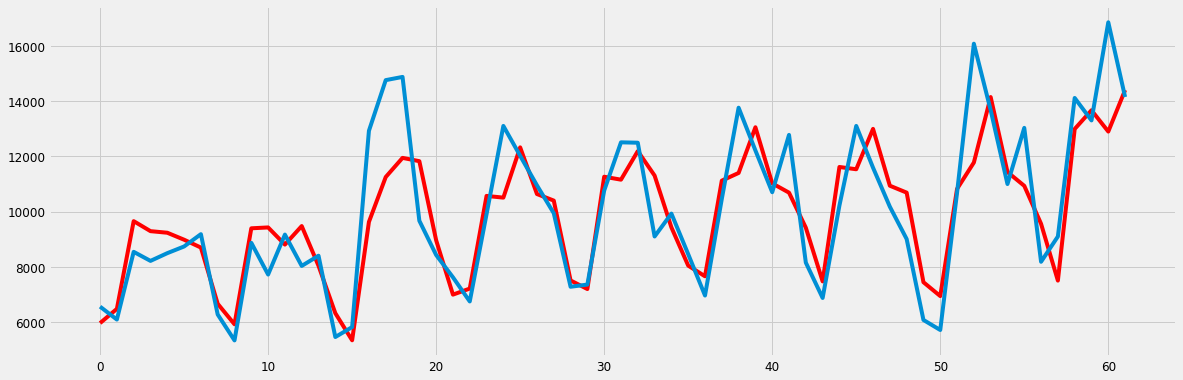

In [37]:
plt.plot(range(0, len(rtp)), rtp, color = 'red')
plt.plot(range(0, len(rtp)), y_test)

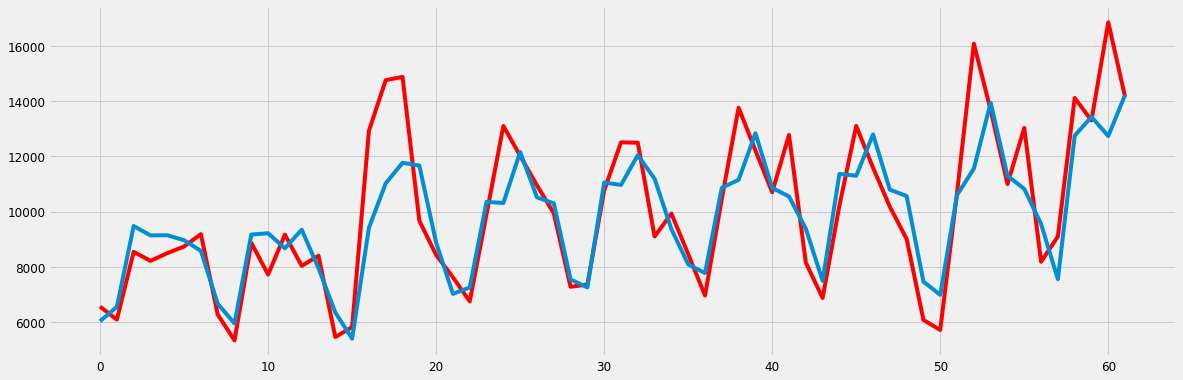

In [38]:
plt.plot(range(0, len(y_old_df[700:])), train_df[700:]['count'], color = 'red')
plt.plot(range(0, len(y_old_df[700:])), y_old_df[700:]['count'])

## Random Forest Regressor

In [39]:
rf = RandomForestRegressor(random_state = 42)
random_grid = {'bootstrap': [True, False], 
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
               'max_features': ['auto', 'sqrt'], 
               'min_samples_leaf': [1, 2, 4], 
               'min_samples_split': [2, 5, 10, 15], 
               'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
              }

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose = 1, random_state = 42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.5min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800, 1000, 1200, 1400,
                                                         1600, 1800, 2000]},
                   random_state=42, verbose=1)

In [40]:
rf_model = RandomForestRegressor(**rf_random.best_params_)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, n_estimators=1600)

In [41]:
rtp = rf_model.predict(X_test)
print(forecast_accuracy(np.array(rtp), np.array(y_test)))

{'mape': 0.045680702528054395, 'me': 45.26169354838718, 'mae': 457.18536290322584, 'mpe': 0.012735698373635142, 'rmse': 588.404838897595, 'acf1': 0, 'corr': 0.9810107442893736, 'minmax': 0.043683095092631796}


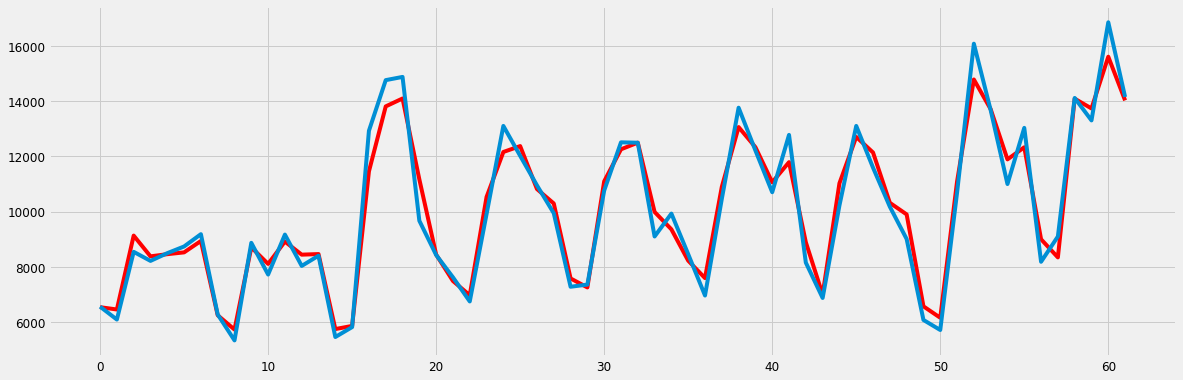

In [42]:
plt.plot(range(0, len(rtp)), rtp, color = 'red')
plt.plot(range(0, len(rtp)), y_test)

In [43]:
linear_pred = linear.predict(testing_df)

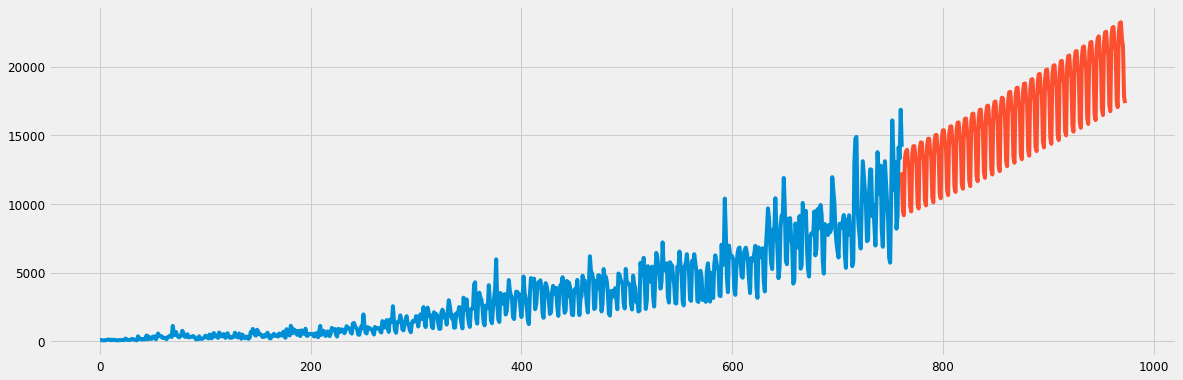

In [44]:
plt.plot(df.index, df.Count)
plt.plot(testing_df.index + 761, linear_pred)

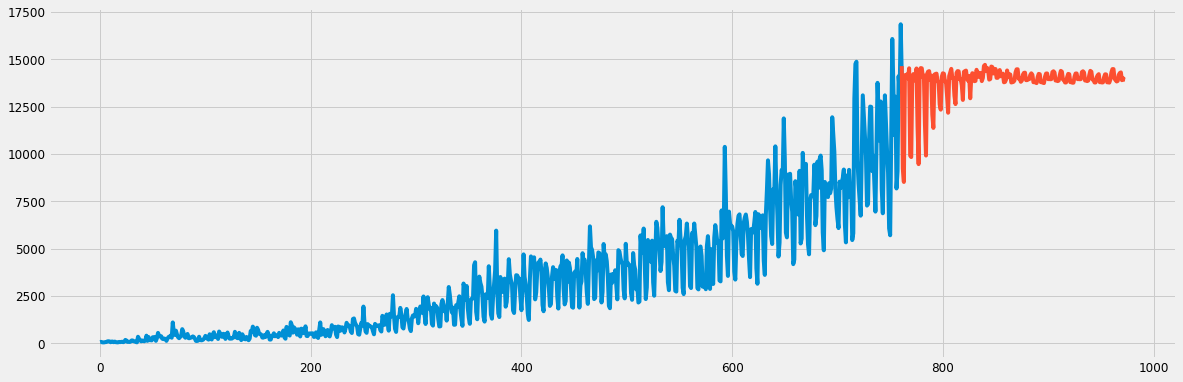

In [45]:
rf_test_pred = rf_model.predict(testing_df)
plt.plot(df.index, df.Count)
plt.plot(testing_df.index + 761, rf_test_pred)

In [46]:
rf_test_pred.sum()

2955206.4887499996

## Ensembles

In [47]:
ensemble_preds = (y_new + f_preds + linear_pred) / 3

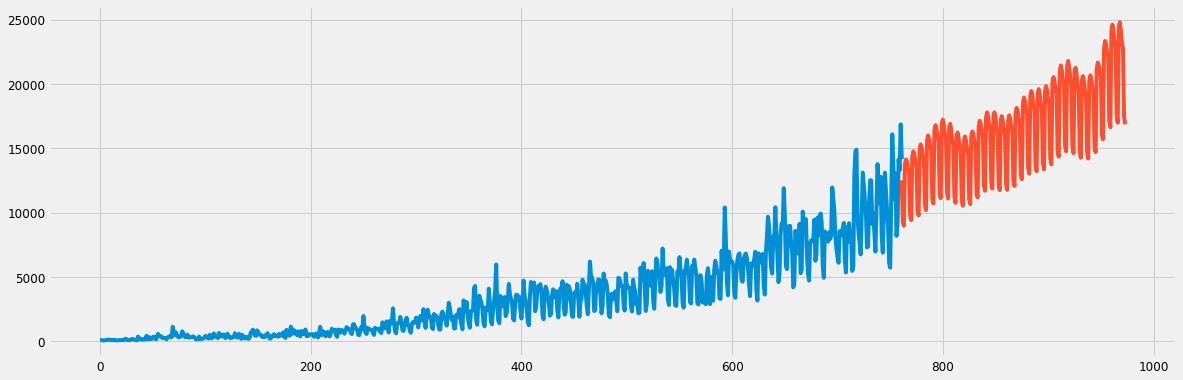

In [48]:
plt.plot(X_train.index, y_train)
plt.plot(testing_df.index + 761, ensemble_preds)

In [49]:
er = []
listm = [0.044286588, 
         0.035343014, 
         0.029911076, 
         0.024714453, 
         0.02080223, 
         0.018621427, 
         0.020023091, 
         0.023221497, 
         0.026741002, 
         0.034555218,
         0.049047207, 
         0.05437526, 
         0.054951351, 
         0.048600186, 
         0.051965438, 
         0.051309072, 
         0.049999488, 
         0.051164262, 
         0.052423477, 
         0.055626605, 
         0.053455246, 
         0.049894816, 
         0.050075828, 
         0.048892166]
for p in range(len(ensemble_preds)):
    for l in range(len(listm)):
        er.append(ensemble_preds[p]*listm[l])
d = {'Count': er}
predf = pd.DataFrame(data = d)
submission_df = pd.DataFrame({
                  "ID": pd.Series([x + 18288 for x in range(5112)]),
                  "Count": pd.Series(predf['Count'])})
submission_df.to_csv('submission_FBprophet.csv', index = False)